In [9]:
import torch
from torch import optim
from torch.utils.data import random_split

from models import SmallUNet
from datasets import SegmentationDataset
from loss import DiceLoss
# from trainer import train
from metrics import calculate_dice_score

import matplotlib.pyplot as plt

In [54]:

def visualize_results(model, data_loader, device, epoch, save_path='./visualizations'):
    """
    Visualize model predictions against ground truth for a batch of images.
    
    Args:
        model: The trained model
        data_loader: DataLoader containing the validation/test data
        device: Device to run the model on
        epoch: Current epoch number
        save_path: Directory to save the visualization plots
    """
    import os
    os.makedirs(save_path, exist_ok=True)
    
    model.eval()
    with torch.no_grad():
        # Get a batch of data
        images, labels = next(iter(data_loader))
        images, labels = images.to(device), labels.to(device)
        
        # Get model predictions
        outputs = model(images)
        predictions = (outputs > 0.5).float()
        
        # Create a figure with a grid of subplots
        num_samples = min(4, images.shape[0])  # Show up to 4 samples
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        
        for idx in range(num_samples):
            # Original image
            axes[idx, 0].imshow(images[idx, 0].cpu().numpy(), cmap='gray')
            axes[idx, 0].set_title('Input Image')
            axes[idx, 0].axis('off')
            
            # Ground truth
            axes[idx, 1].imshow(labels[idx, 0].cpu().numpy(), cmap='gray')
            axes[idx, 1].set_title('Ground Truth')
            axes[idx, 1].axis('off')
            
            # Model prediction
            axes[idx, 2].imshow(predictions[idx, 0].cpu().numpy(), cmap='gray' , vmin=0, vmax=1)
            axes[idx, 2].set_title('Model Prediction')
            axes[idx, 2].axis('off')
        
        plt.tight_layout()
        plt.show()

In [61]:
import numpy as np
def train(model, train_loader, criterion, optimizer, device, num_epochs):
    """
    Training function with visualization every 10 epochs.
    
    Args:
        model: The model to train
        train_loader: DataLoader containing the training data
        criterion: Loss function
        optimizer: Optimizer
        device: Device to run the training on
        num_epochs: Number of epochs to train for
    """
    model.train()
    acc_loss = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            acc_loss.append(loss.item())
            
        # Print epoch statistics
        epoch_loss = running_loss / len(train_loader)
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
        # Visualize results every 10 epochs
        if (epoch + 1) % 100== 0:
            visualize_results(model, train_loader, device, epoch + 1)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
            fig , ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(outputs[0, 0].detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
            ax[0].set_title(f'max: {torch.max(outputs[0, 0]):.2f}, min: {torch.min(outputs[0, 0]):.2f}')
            ax[1].hist(outputs[0, 0].detach().cpu().numpy().flatten(), bins=50)
            ax[2].plot(np.convolve(acc_loss, np.ones(20)/20, mode='valid'))
            model.train()  # Set back to training mode

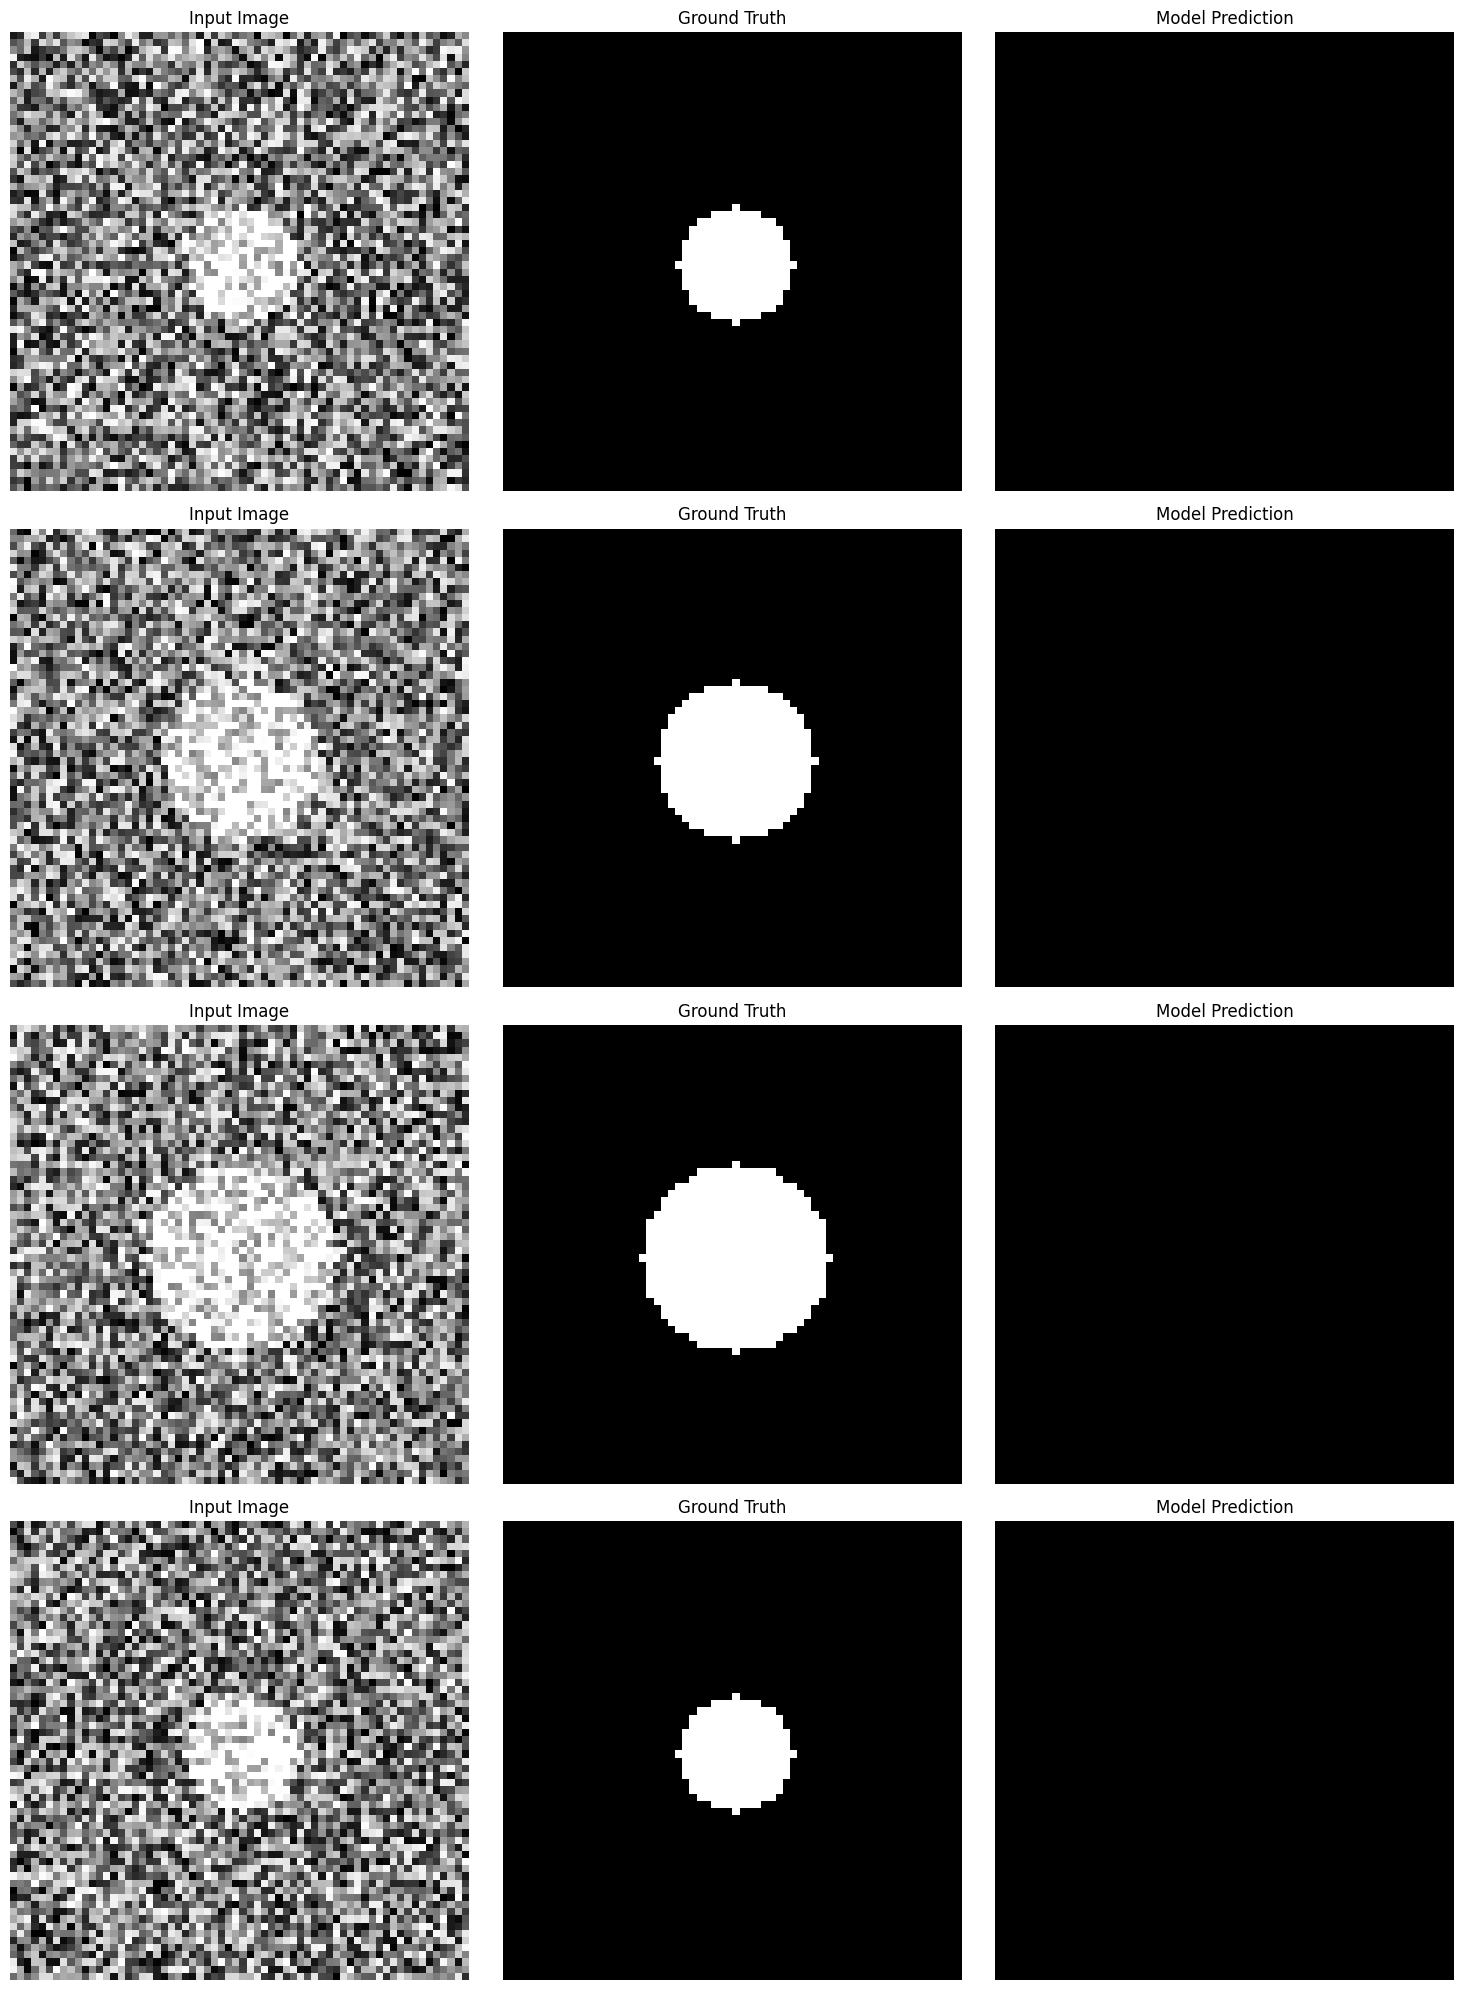

Epoch [100/500], Loss: 0.8175


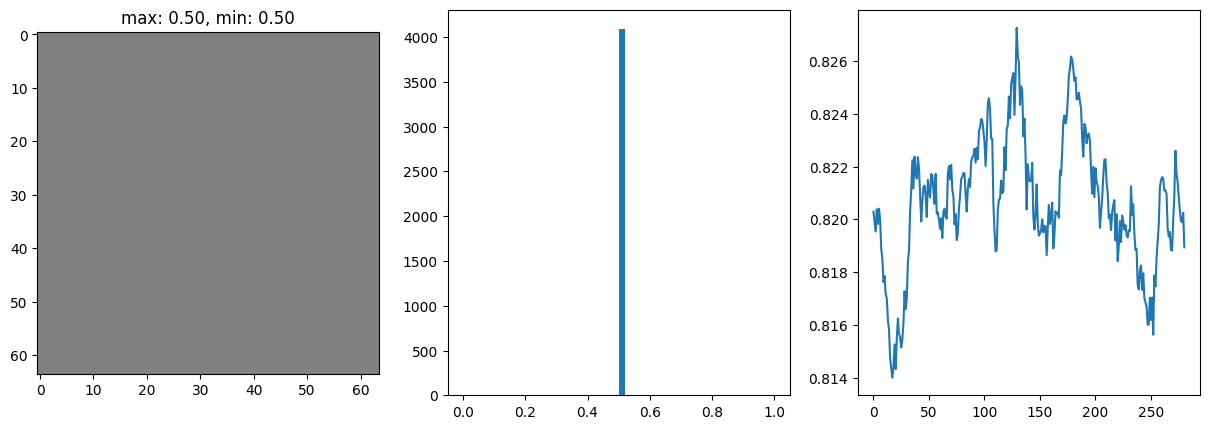

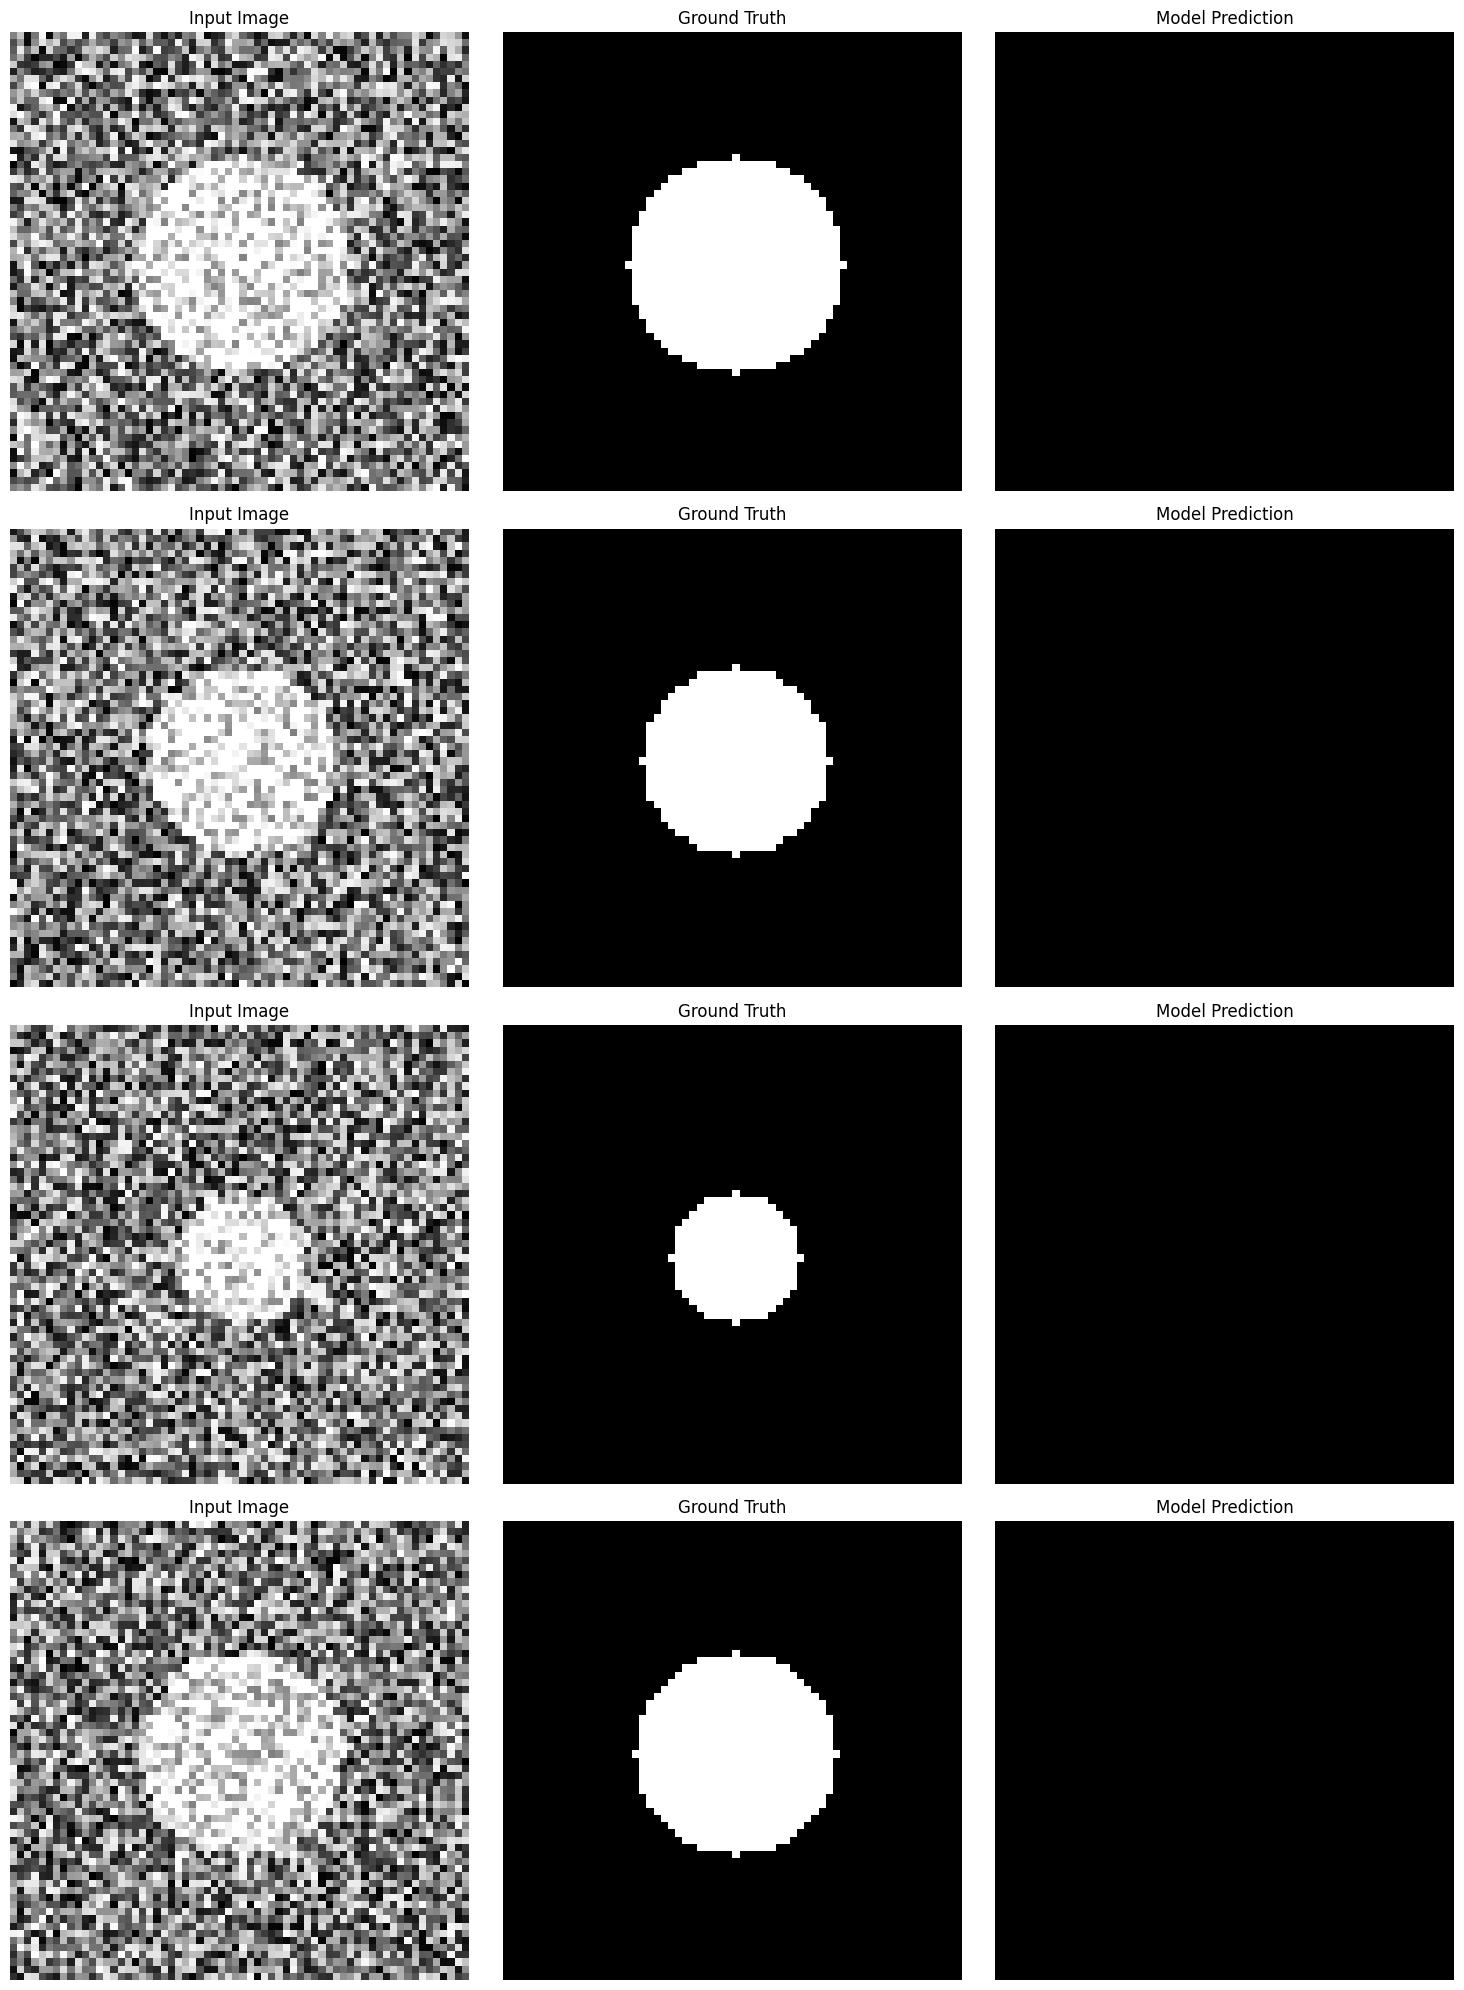

Epoch [200/500], Loss: 0.8221


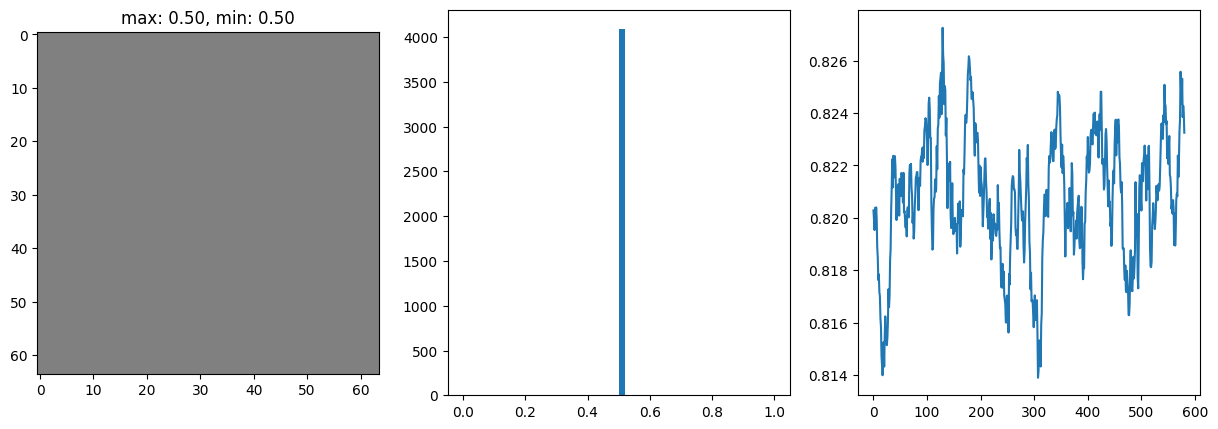

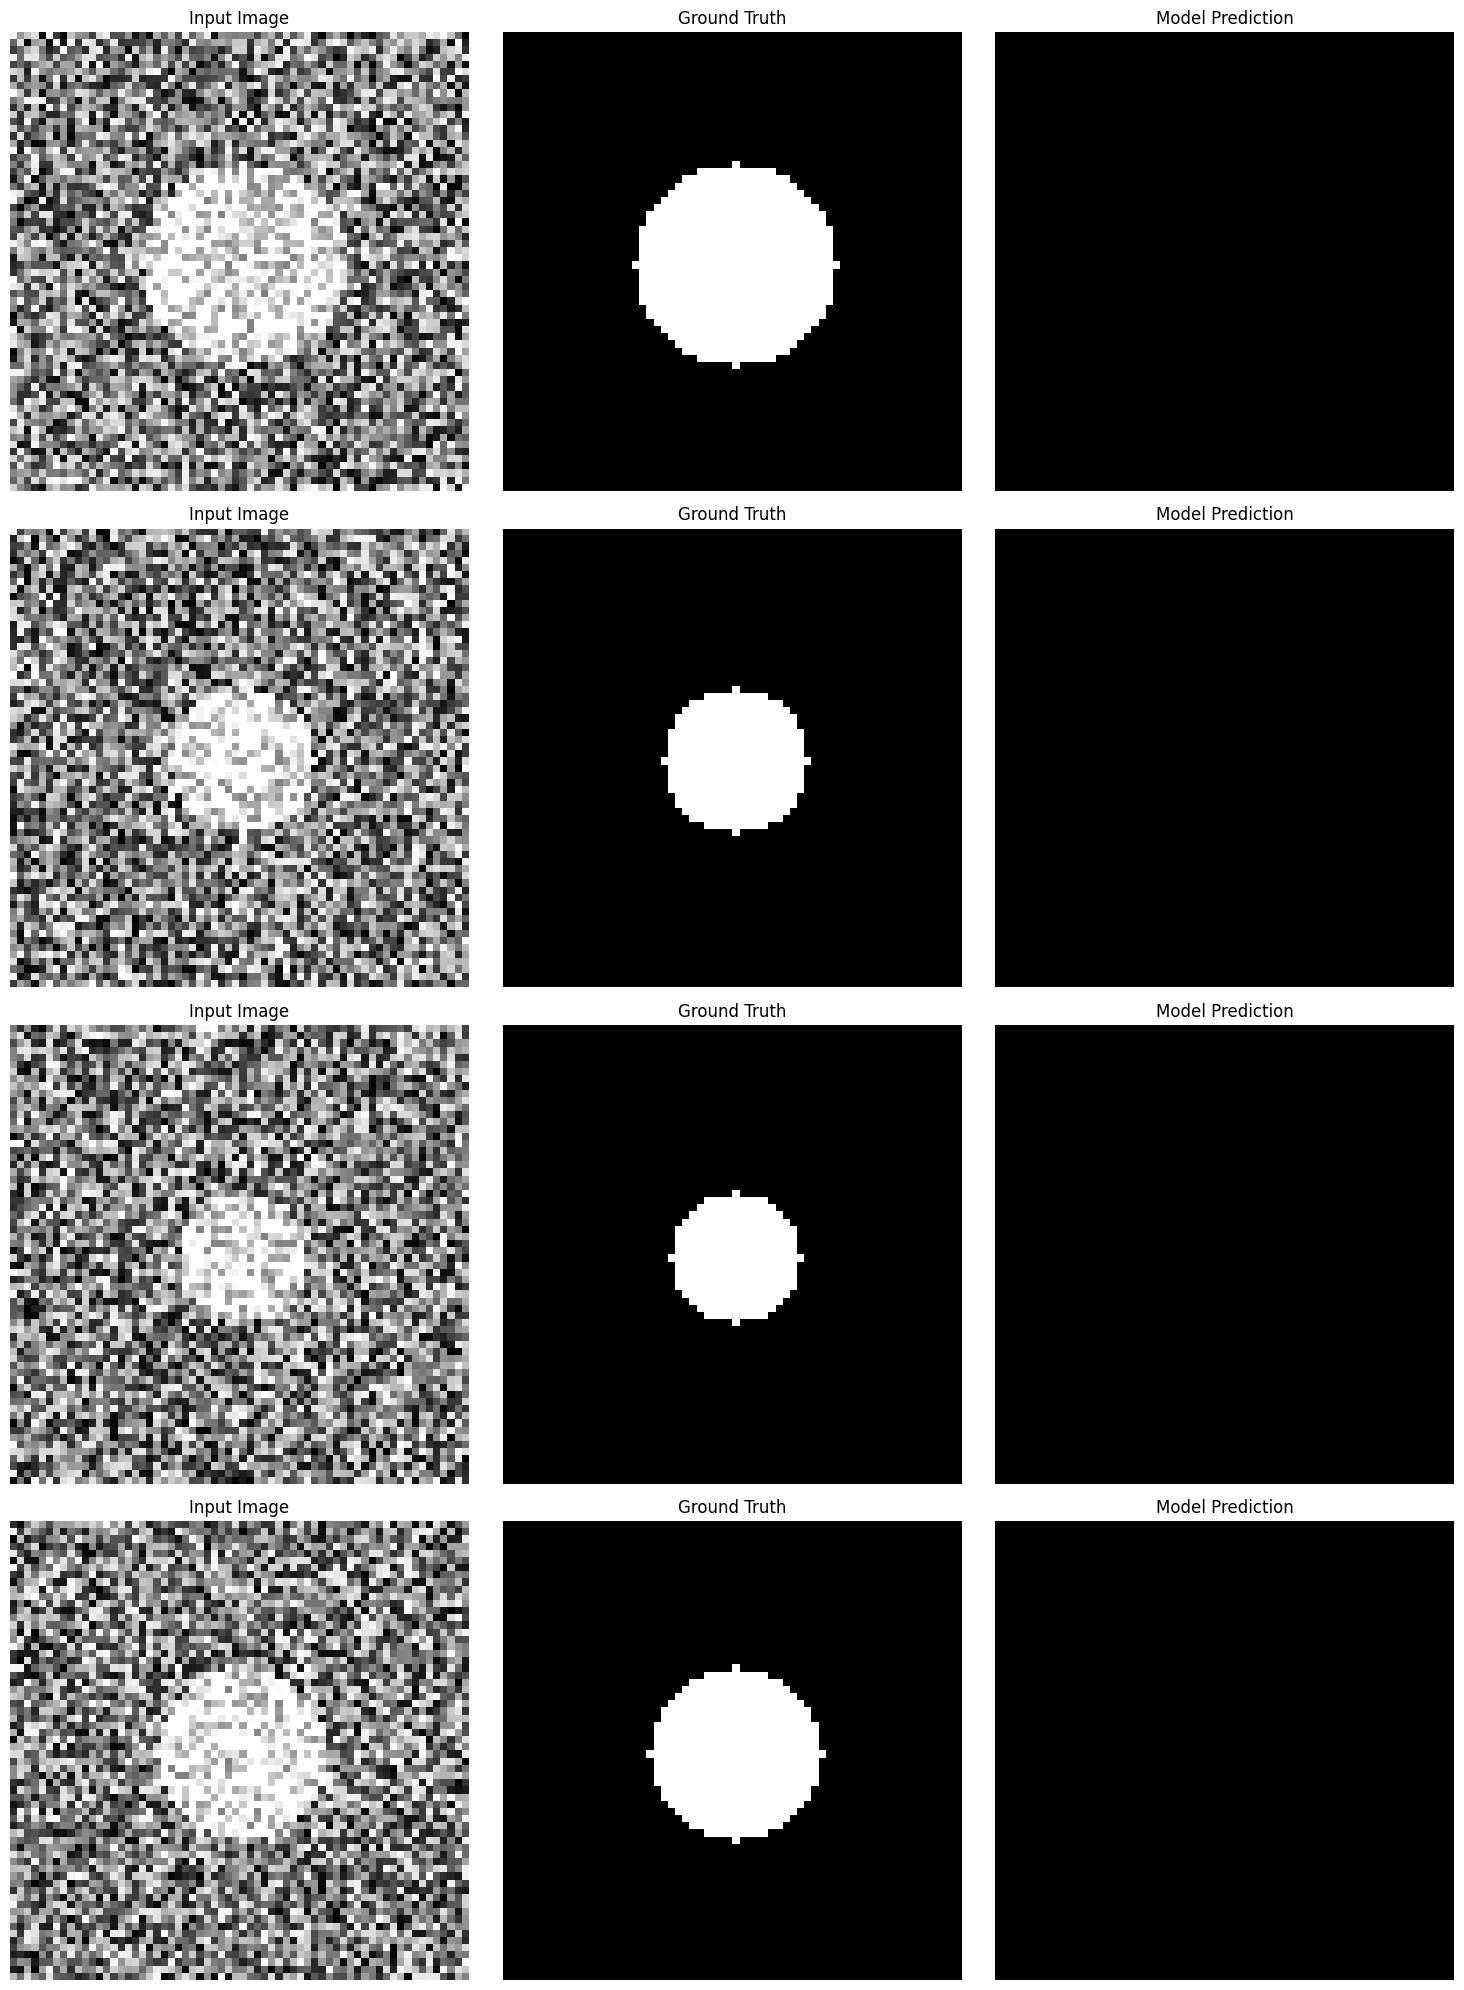

Epoch [300/500], Loss: 0.8185


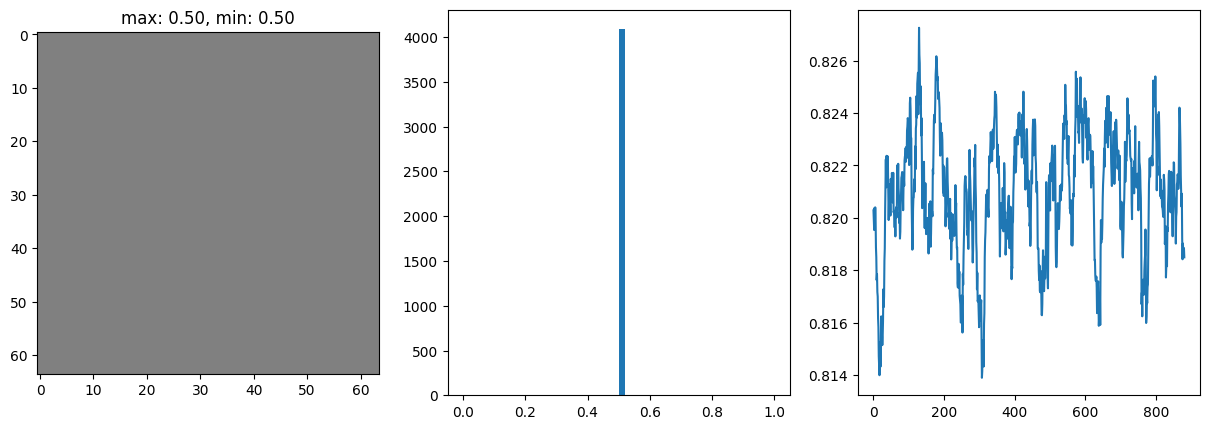

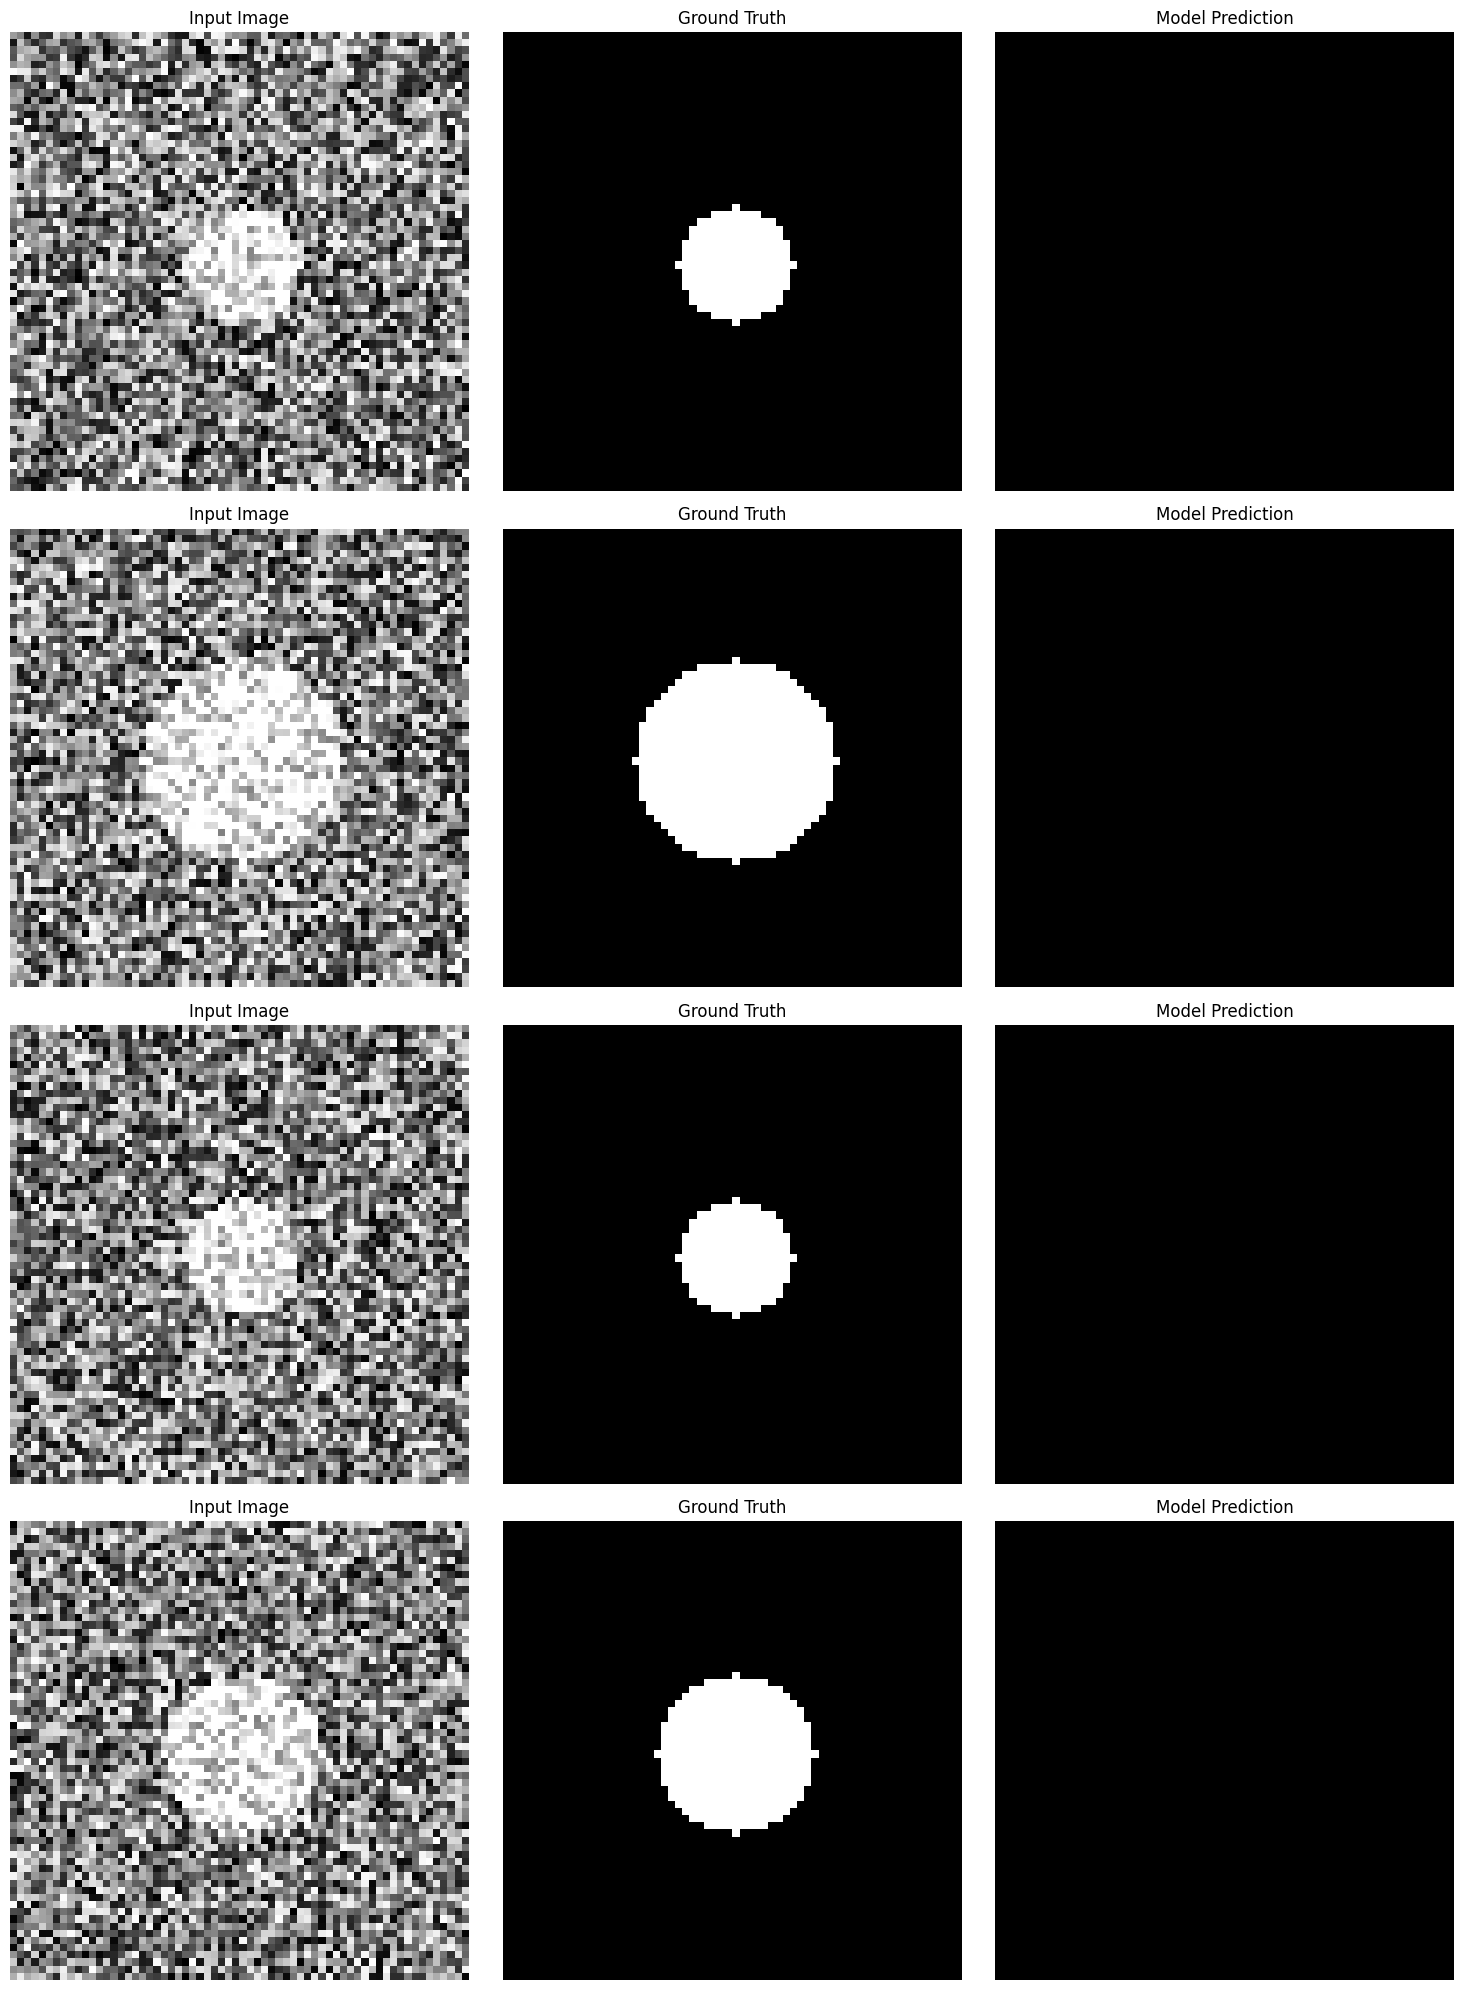

Epoch [400/500], Loss: 0.8148


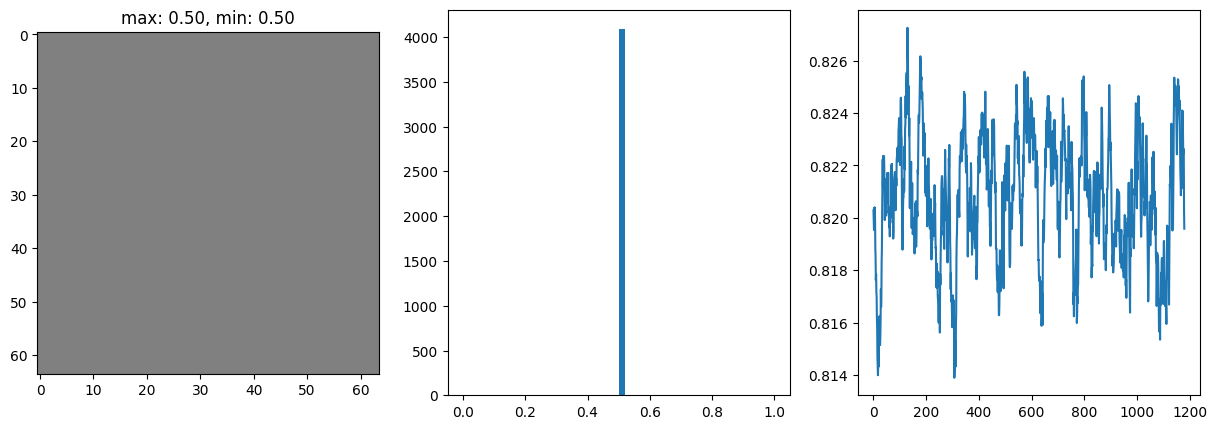

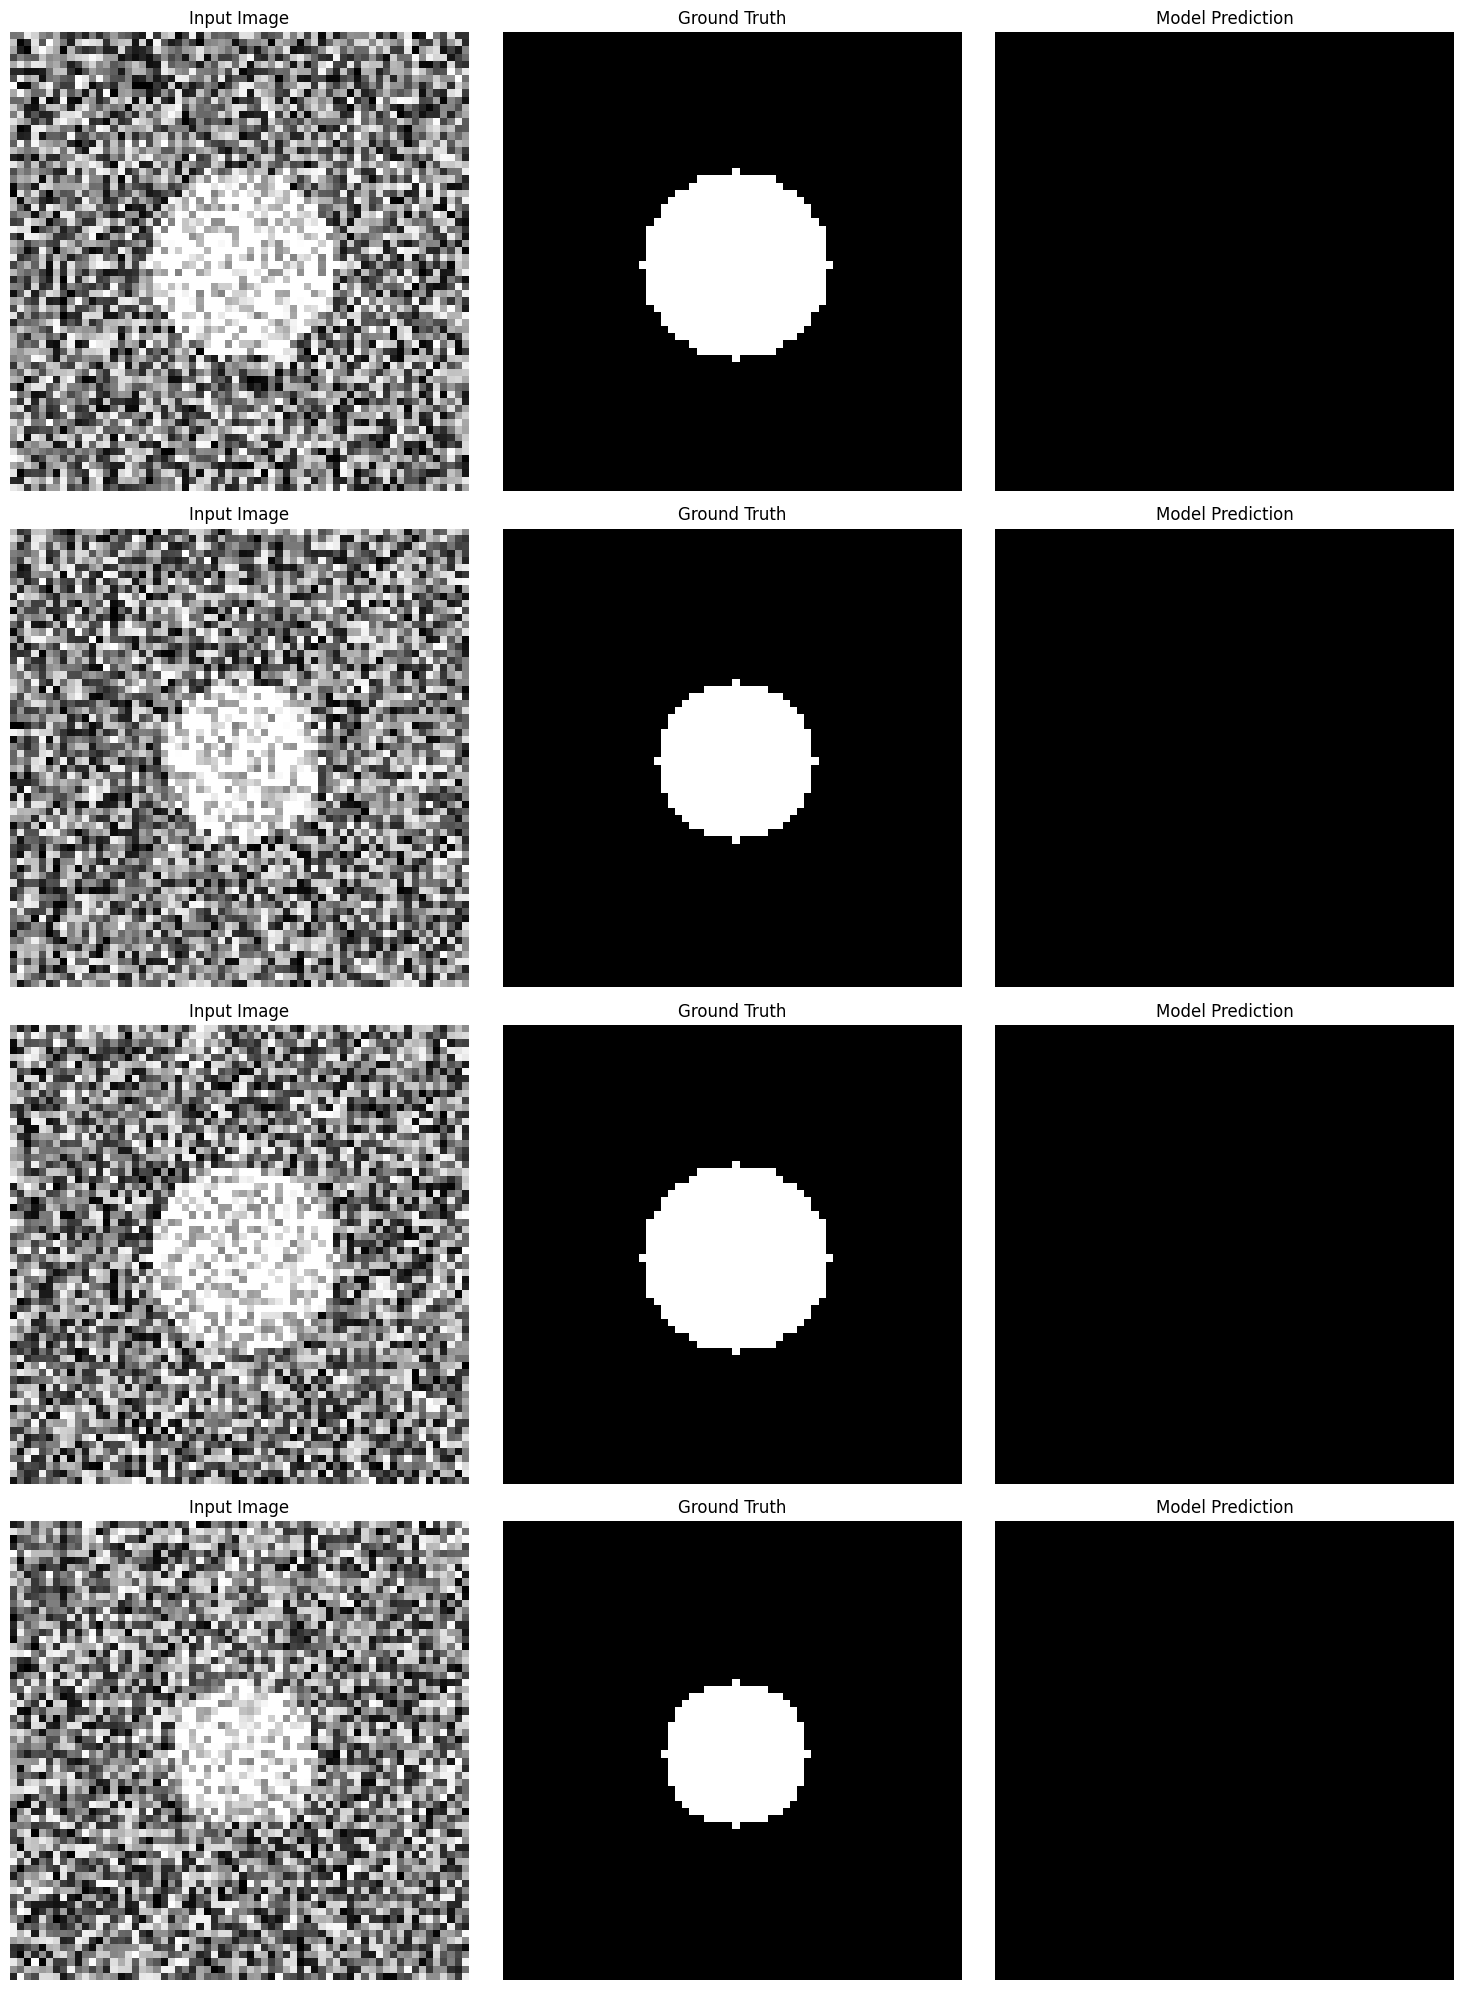

Epoch [500/500], Loss: 0.8278
Normal Training completed!
Dice score: 0.0


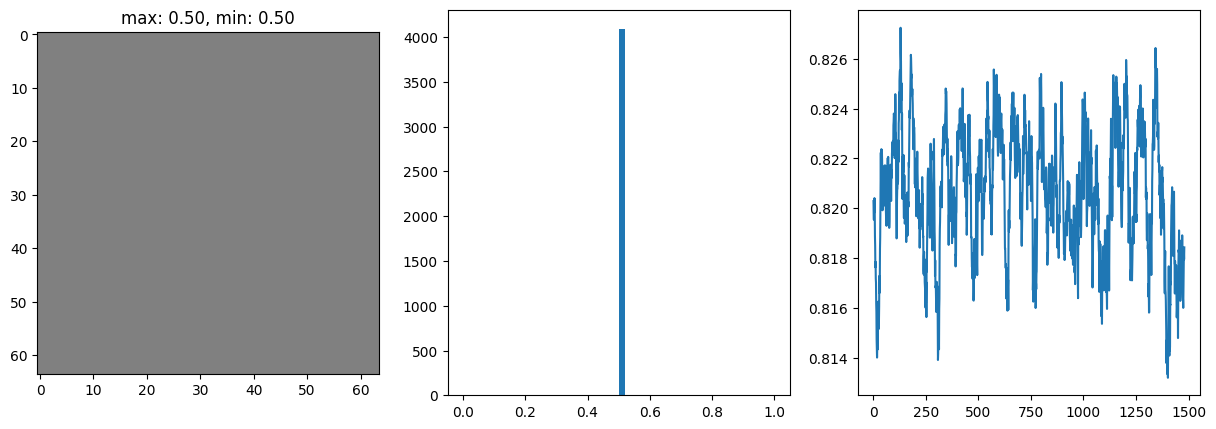

In [62]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size =32
num_epochs = 500
learning_rate = 1e-3

# MedDecathalon dataset Task04_Hippocampus
dataset = SegmentationDataset()

# Split dataset into training and test sets
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% for training
test_size = total_size - train_size  # Remaining 20% for test

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = SmallUNet(in_channels=1, out_channels=1).to(device)

criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train(model, train_loader, criterion, optimizer, device, num_epochs)
print("Normal Training completed!")

# Calculate the dice score
dice_score = calculate_dice_score(model, test_loader, device)
print(f"Dice score: {dice_score}")
